In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# Remove the old path if it exists
#old_path = '/Users/maxw/projects/bayes_gsl'
#if old_path in sys.path:
#    sys.path.remove(old_path)

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)
""" 
# Append the new src directory to the system path
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

# Confirm that the src directory is in the system path
print("Current sys.path:")
for path in sys.path:
    print(path)

"""
# Now try importing your module using the absolute path as a check
from src.models import dpg_bnn


In [2]:
"""
    Compare all models on NLL, BS, Error, ECE.
    Plot the calibration curves and the distribution of probabilities within each bin.

"""
import os
import pickle
import arviz
import matplotlib.pyplot as plt
import numpyro.infer
import seaborn as sns
from sklearn.calibration import calibration_curve
import numpy as np

import jax.numpy as jnp
import jax


from src import TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH, FIGURES_PATH

from src.models import dpg_bnn, dpg_mimo_bnn, dpg_mimo_stochastic_head, pds_bnn
#from src.data import load_data
from src.metrics import compute_metrics

from src.config import num_samples_to_generate, w_init_scale, lam_init_scale, altered_prior
from experiments.iid_generalization.config import dpg_hyperparameters, pds_hyperparameters, dpg_mimo_hyperparameters, dpg_mimo_e_hyperparameters, experiment_settings
from src import NUM_BINS

In [3]:
from experiments.iid_generalization.config import dpg_hyperparameters, pds_hyperparameters, dpg_mimo_hyperparameters, dpg_mimo_e_hyperparameters, experiment_settings
models = {
        'DPG': (dpg_bnn, dpg_hyperparameters, f"dpg_D={dpg_hyperparameters['depth']}.pkl"),
        'PDS': (pds_bnn, pds_hyperparameters, f"pds_D={dpg_hyperparameters['depth']}.pkl"),
        'DPG-MIMO': (dpg_mimo_bnn, dpg_mimo_hyperparameters, f"dpg_mimo_D={dpg_mimo_hyperparameters['depth']}_C={dpg_mimo_hyperparameters['num_channels']}.pkl"),
        'DPG-MIMO-E': (dpg_mimo_stochastic_head, dpg_mimo_e_hyperparameters, f"dpg_mimo_e_D={dpg_mimo_e_hyperparameters['mimo_base']['depth']}_C={dpg_mimo_e_hyperparameters['mimo_base']['num_channels']}_stoch_head_C={dpg_mimo_e_hyperparameters['num_stochastic_channels']}_D={dpg_mimo_e_hyperparameters['stochastic_head_depth']}.pkl")
    }

In [16]:
# load the results from dictionary
from experiments.covariate_shift.run import PATH2COVARIATE_SHIFT_RESULTS, display_metrics
covariate_shift_metrics_file = os.path.join(PATH2COVARIATE_SHIFT_RESULTS, 'covariate_shift_metrics.pkl')

# ensure the file exists, if not warn user
if not os.path.exists(covariate_shift_metrics_file):
    print(f"The file {covariate_shift_metrics_file} does not exist. Please run the covariate shift experiment first.")

with open(covariate_shift_metrics_file, 'rb') as f:
    model_metrics_dicts = pickle.load(f)

for model_name, num_signals_to_metrics_dict in model_metrics_dicts.items():
    print(model_name)
    for num_signals, metrics_dict in num_signals_to_metrics_dict.items():
        print(num_signals)
        display_metrics(metrics_dict)
        print()

DPG
expected
Test Error: 0.01568425 \pm 0.01049944
Test NLL: 10.498 \pm 5.094
Test BS: 0.01286666 \pm 0.00707457
Test ECE:0.00205676

10
Test Error: 0.14631581 \pm 0.05204941
Test NLL: 137.678 \pm 44.252
Test BS: 0.13254696 \pm 0.04587125
Test ECE:0.12214946

20
Test Error: 0.10042101 \pm 0.04362825
Test NLL: 77.796 \pm 31.583
Test BS: 0.08689437 \pm 0.03663775
Test ECE:0.07404078

100
Test Error: 0.03668422 \pm 0.02318724
Test NLL: 22.782 \pm 13.591
Test BS: 0.03015053 \pm 0.01790753
Test ECE:0.01649673

1000
Test Error: 0.01773685 \pm 0.01103143
Test NLL: 11.498 \pm 5.345
Test BS: 0.01453711 \pm 0.00775873
Test ECE:0.00242110

10000
Test Error: 0.01547366 \pm 0.01014630
Test NLL: 10.557 \pm 5.105
Test BS: 0.01297524 \pm 0.00728754
Test ECE:0.00194290

PDS
expected
Test Error: 0.01568425 \pm 0.01057829
Test NLL: 10.487 \pm 5.113
Test BS: 0.01285614 \pm 0.00707742
Test ECE:0.00205337

10
Test Error: 0.14631581 \pm 0.05199616
Test NLL: 136.734 \pm 43.474
Test BS: 0.13243671 \pm 0.045854

In [42]:
def list2str(l):
    return ["{:.3f}".format(x) for x in l]

def print_metrics(dict, name, num_signals):
    print(f"{name} metrics:")
    print('\tNLL: ', list2str([-1 * dict[num_signal]['log_likelihoods'].mean()._value for num_signal in num_signals]))
    print('\tBS: ', list2str([dict[num_signal]['brier_scores'].mean()._value for num_signal in num_signals]))
    print('\tError: ', list2str([1 - dict[num_signal]['accuracies'].mean()._value for num_signal in num_signals]))
    print('\tECE: ', list2str([dict[num_signal]['calibration_dict']['ece'] for num_signal in num_signals]))


In [50]:
num_signals = list(model_metrics_dicts['DPG'].keys())
# 'expected' should be first, then the tail should be in decreasing order
num_signals = ['expected'] + [str(x) for x in sorted([int(x) for x in num_signals if x != 'expected'], reverse=True)]
# replace 'expected' with inf
#num_signals = [np.inf if x == 'expected' else float(x) for x in num_signals]
# ensure sorted in decreasing order
#num_signals = sorted(num_signals, reverse=True)
print(num_signals)

for model_name, num_signals_to_metrics_dict in model_metrics_dicts.items():
    print_metrics(num_signals_to_metrics_dict, model_name, num_signals)

['expected', '10000', '1000', '100', '20', '10']
DPG metrics:
	NLL:  ['10.498', '10.557', '11.498', '22.782', '77.796', '137.678']
	BS:  ['0.013', '0.013', '0.015', '0.030', '0.087', '0.133']
	Error:  ['0.016', '0.015', '0.018', '0.037', '0.100', '0.146']
	ECE:  ['0.002', '0.002', '0.002', '0.016', '0.074', '0.122']
PDS metrics:
	NLL:  ['10.487', '10.542', '11.493', '22.749', '77.560', '136.734']
	BS:  ['0.013', '0.013', '0.015', '0.030', '0.087', '0.132']
	Error:  ['0.016', '0.015', '0.018', '0.037', '0.100', '0.146']
	ECE:  ['0.002', '0.002', '0.003', '0.016', '0.074', '0.122']
DPG-MIMO metrics:
	NLL:  ['9.424', '9.456', '10.498', '24.185', '100.108', '188.653']
	BS:  ['0.012', '0.012', '0.013', '0.030', '0.087', '0.132']
	Error:  ['0.014', '0.014', '0.016', '0.038', '0.102', '0.148']
	ECE:  ['0.004', '0.004', '0.003', '0.017', '0.076', '0.122']
DPG-MIMO-E metrics:
	NLL:  ['8.928', '8.931', '9.984', '24.522', '101.566', '190.005']
	BS:  ['0.011', '0.011', '0.013', '0.030', '0.089', '

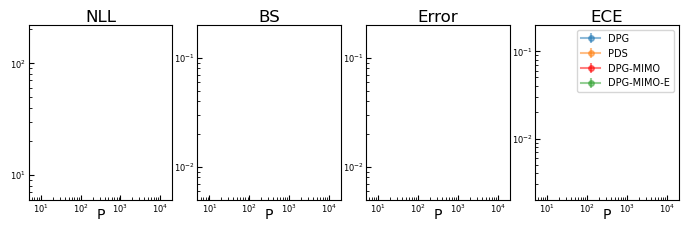

In [47]:
colors = {'DPG': '#1f77b4', 'PDS': '#ff7f0e', 
          'DPG-MIMO': 'red',
          'DPG-MIMO-E': '#2ca02c'}

num_plots = 4
tick_fontsize = 6
label_fontsize = 10
alpha, markersize = 0.5, 4
fig, axes = plt.subplots(1, num_plots, figsize=(TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH))
nll_ax, bs_ax, err_ax, ece_ax = axes
stdv_scale = 1

for ax, title in zip(axes, ['NLL', 'BS', 'Error', 'ECE']):
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.title.set_text(title)
    ax.set_title(title, y=.97)
    ax.tick_params(axis='both', which='both', direction='in', pad=2, labelsize=tick_fontsize)
    ax.set_xlabel('P', fontsize=label_fontsize, labelpad=-5)
    ax.set_xlim([5, 20000])
    ax.set_xticks([10, 100, 1000, 10000])
    ax.set_xticklabels([r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'], fontsize=tick_fontsize)
    # set size of y tick labels



""" NLL """
for name in model_metrics_dicts.keys():
    nll_ax.errorbar(
        num_signals,
        [-1 * model_metrics_dicts[name][num_signal]['log_likelihoods'].mean()._value for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['log_likelihoods'].std()._value for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
nll_ax.set_ylim([6, 220])
#nll_ax.set_yticks([10, 15, 20, 25])
# clear all yticklabels and set manually
#nll_ax.set_yticklabels([10, 15, 20, 25], fontsize=tick_fontsize)

# Brier Score
for name in model_metrics_dicts.keys():
    bs_ax.errorbar(
        num_signals,
        [model_metrics_dicts[name][num_signal]['brier_scores'].mean()._value for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['brier_scores'].std()._value for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
bs_ax.set_ylim([0.005, 0.2])
#bs_ax.set_yticks([0.1, 0.2, 0.3, 0.4])
#bs_ax.set_yticklabels(['.1', '.2', '.3', '.4'], fontsize=tick_fontsize)
#bs_ax.legend(loc='upper right', fontsize=label_fontsize-3)

# Error
for name in model_metrics_dicts.keys():
    err_ax.errorbar(
        num_signals,
        [1 - model_metrics_dicts[name][num_signal]['accuracies'].mean() for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['accuracies'].std() for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
err_ax.set_ylim([0.005, 0.2])
#err_ax.set_yticks([0.01, 0.1, 0.2])
#err_ax.set_yticklabels(['.01', '.1', '.2'], fontsize=tick_fontsize)

# ECE
for name in model_metrics_dicts.keys(): #['dpg', 'pds', 'mimo', 'partial_stoch']:
    ece_ax.errorbar(
        num_signals,
        [model_metrics_dicts[name][num_signal]['calibration_dict']['ece'].mean() for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['calibration_dict']['ece'].std() for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
ece_ax.set_ylim([.002, .2])
#ece_ax.set_yticks([.01, .1])
#ece_ax.set_yticklabels(['.01', '.1'], fontsize=tick_fontsize)
ece_ax.legend(loc='upper right', fontsize=label_fontsize-3)


space = .175
plt.subplots_adjust(wspace=space, hspace=space, bottom=0.0, top=1, left=0.0, right=1.0)

In [4]:
def display_metrics(metrics_dict):
    calibration_dict = metrics_dict['calibration_dict']
    print(f'Test Error: {1 - metrics_dict["accuracies"].mean():.5f} \pm {metrics_dict["accuracies"].std():.5f}')
    print(f'Test NLL: {-1 * metrics_dict["log_likelihoods"].mean():.3f} \pm {metrics_dict["log_likelihoods"].std():.3f}')
    print(f'Test BS: {metrics_dict["brier_scores"].mean():.5f} \pm {metrics_dict["brier_scores"].std():.5f}')
    print(f'Test ECE:{calibration_dict["ece"]:.5f}') 


In [5]:
# load the metrics for each model
model_metrics = {}
# Run experiments for each model
for name, (model, params, results_file) in models.items():
    results_path = os.path.join(experiment_settings['results_path'], results_file)
    print(f"\n**** {name} ****")
    if os.path.exists(results_path):
        print(f"Metrics found at {results_path}.")
        # Load results
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
            #samples_key = 'samples' if name != 'dpg_mimo' else 'map point estimates'
            samples, metrics_dict = results['samples'], results['metrics']
            model_metrics[name] = metrics_dict
            display_metrics(metrics_dict)



**** dpg ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/dpg_D=200.pkl.
Test Error: 0.01574 \pm 0.01008
Test NLL: 10.332 \pm 5.372
Test BS: 0.01286 \pm 0.00716
Test ECE:0.00316

**** pds ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/pds_D=200.pkl.
Test Error: 0.01589 \pm 0.01026
Test NLL: 10.316 \pm 5.386
Test BS: 0.01284 \pm 0.00717
Test ECE:0.00361

**** dpg_mimo ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/dpg_mimo_D=200_C=4.pkl.
Test Error: 0.01416 \pm 0.00941
Test NLL: 9.191 \pm 5.155
Test BS: 0.01188 \pm 0.00665
Test ECE:0.00350

**** dpg_mimo_e ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/dpg_mimo_e_D=200_C=4_stoch_head_C=2_D=20.pkl.
Test Error: 0.01289 \pm 0.00823
Test NLL: 8.354 \pm 4.738
Test BS: 0.01065 \pm 0.00604
Test ECE:0.00240


hi


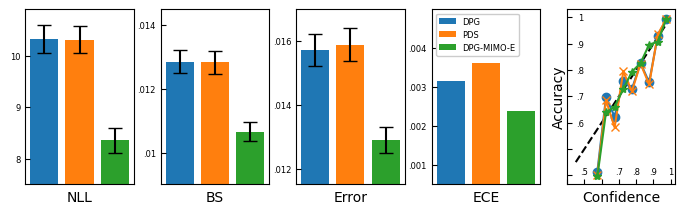

In [8]:
"""
    Make plot
"""
dpg_metrics = model_metrics['dpg']
pds_metrics = model_metrics['pds']
partial_stoch_metrics = model_metrics['dpg_mimo_e']

num_plots = 5
tick_fontsize = 6
label_fontsize = 10
fig, axes = plt.subplots(1, num_plots, figsize=(TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH))
nll_ax, bs_ax, err_ax, ece_ax, cal_ax = axes


# first 4 plots: barplots (with stdv) of are the NLL, BS, Error, ECE for each model
stdv_scale = 1/20
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
# NLL
means = [-1*dpg_metrics['log_likelihoods'].mean(),
         -1*pds_metrics['log_likelihoods'].mean(),
         -1*partial_stoch_metrics['log_likelihoods'].mean()]
stdvs = np.array([dpg_metrics['log_likelihoods'].std(),
                  pds_metrics['log_likelihoods'].std(),
                  partial_stoch_metrics['log_likelihoods'].std()])
nll_ax.bar([0, 1, 2], means, yerr=stdv_scale*stdvs, capsize=5, color=colors)
nll_ax.set_xlabel('NLL', fontsize=label_fontsize)
nll_ax.set_ylim([7.5, 10.9])
nll_ax.set_yticks([8, 9, 10])
nll_ax.set_yticklabels([8, 9, 10], fontsize=tick_fontsize)

# BS
means = [dpg_metrics['brier_scores'].mean(),
         pds_metrics['brier_scores'].mean(),
         partial_stoch_metrics['brier_scores'].mean()]
stdvs = np.array([dpg_metrics['brier_scores'].std(),
                  pds_metrics['brier_scores'].std(),
                  partial_stoch_metrics['brier_scores'].std()])
bs_ax.clear()
bs_ax.bar([0, 1, 2], means, yerr=stdv_scale*stdvs, capsize=5, color=colors)
bs_ax.set_xlabel('BS', fontsize=label_fontsize)
#bs_ax.set_yscale('log')
bs_ax.set_ylim([.009, .0145])
bs_ax.set_yticks([1.0e-2, 1.2e-2, 1.4e-2])
bs_ax.set_yticklabels(['.01', '.012', '.014'], fontsize=tick_fontsize)

# Error
means = [1 - dpg_metrics['accuracies'].mean(),
         1 - pds_metrics['accuracies'].mean(),
         1 - partial_stoch_metrics['accuracies'].mean()]
stdvs = np.array([
    dpg_metrics['accuracies'].std(),
    pds_metrics['accuracies'].std(),
    partial_stoch_metrics['accuracies'].std()])
err_ax.clear()
err_ax.bar([0, 1, 2], means, yerr=stdv_scale*stdvs, capsize=5, color=colors)
err_ax.set_xlabel('Error', fontsize=label_fontsize)
#err_ax.set_yscale('log')
err_ax.set_ylim([.0115, .017])
err_ax.set_yticks([.012, .014, .016])
err_ax.set_yticklabels(['.012', '.014', '.016'], fontsize=tick_fontsize)

# ECE
ece_ax.clear()
ece_ax.bar([0, 1, 2],
           [dpg_metrics['calibration_dict']['ece'],
            pds_metrics['calibration_dict']['ece'],
            partial_stoch_metrics['calibration_dict']['ece']],
           #label=['dpg', 'pds', 'dpg-mimo-e'], 
           label=['DPG', 'PDS', 'DPG-MIMO-E'],
           color=colors)
ece_ax.set_xlabel('ECE', fontsize=label_fontsize)
ece_ax.set_yscale('linear')
ece_ax.set_ylim([.0005, .005])
ece_ax.set_yticks([.001, .002, .003, .004])
ece_ax.set_yticklabels(['.001', '.002', '.003', '.004'], fontsize=tick_fontsize)
ece_ax.legend(loc='upper left', fontsize=tick_fontsize, framealpha=1.0)
#ece_ax.set_ylim([.95, 1.05])

# last plot: calibration plot
cal_ax.clear()
cal_ax.plot([0.45, 1], [.45, 1], 'k--') #, label='Perfect') # Calibration')
# x is the center of the NUM_BINS uniform bins between 0.5 and 1
x = np.linspace(0.5, 1, NUM_BINS, endpoint=False) + 1/(4*NUM_BINS)
alpha=1.0
for calibration_dict, label, marker in \
        zip([dpg_metrics['calibration_dict'],
             pds_metrics['calibration_dict'],
             partial_stoch_metrics['calibration_dict']],
            ['base', 'pds', 'dpg-mimo-e'],
            ['o', 'x', '*']):
    bin_counts = calibration_dict['bin_counts']
    mask = bin_counts > 0
    cal_ax.plot(x[mask],
                calibration_dict['bin_acc'][mask],
                alpha=alpha,
                marker=marker,
                label=label)

cal_ax.tick_params(axis='y', direction='in')
# move y-label to right

cal_ax.set_yticks([.4, .5, .6, .7, .8, .9, 1])
cal_ax.set_yticklabels(['', '', '.6', '.7', '.8', '.9', '1'], fontsize=tick_fontsize)
cal_ax.set_xticks([.4, .5, .6, .7, .8, .9, 1])
cal_ax.set_xticklabels(['', '.5', '', '.7', '.8', '.9', '1'], fontsize=tick_fontsize)
cal_ax.tick_params(axis='both', which='major', pad=-12, direction='in')
cal_ax.set_ylabel('Accuracy', fontsize=label_fontsize, labelpad=1)
cal_ax.set_xlabel('Confidence', fontsize=label_fontsize, labelpad=4)
#cal_ax.legend(loc='upper left', fontsize=tick_fontsize, framealpha=1.0)

for ax in [nll_ax, bs_ax, err_ax, ece_ax]:
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='y', direction='in')
    #ax.set_xlabel('')
    # remove borders
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

print('hi')
space = .25
plt.subplots_adjust(wspace=space, hspace=space, bottom=0.0, top=1, left=0.0, right=1.0) # SAVE FIG AND INSPECT BEFORE CHANGING!
plt.savefig(FIGURES_PATH + 'iid_generalization', dpi=1000, bbox_inches="tight", pad_inches=0.02)
plt.show(block=False)